In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.linalg
import scipy
import copy
import math
import os

In [2]:
# (0,2,1)(2,1,0)->(2,0,1)

op1 = np.array([0,2,1])
op2 = np.array([2,1,0])
op_out = op2[op1]

path = "./results/fig5d/"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

# Python function to print permutations of a given list
def permutation(lst):
 
    # If lst is empty then there are no permutations
    if len(lst) == 0:
        return []
 
    # If there is only one element in lst then, only
    # one permutation is possible
    if len(lst) == 1:
        return [lst]
 
    # Find the permutations for lst if there are
    # more than 1 characters
 
    l = [] # empty list that will store current permutation
 
    # Iterate the input(lst) and calculate the permutation
    for i in range(len(lst)):
       m = lst[i]
 
       # Extract lst[i] or m from the list.  remLst is
       # remaining list
       remLst = lst[:i] + lst[i+1:]
 
       # Generating all permutations where m is first
       # element
       for p in permutation(remLst):
           l.append([m] + p)
    return l
 

p = 3
data = list(np.arange(p))
perms = []
perm2id = {}
id_ = 0
for perm in permutation(data):
    perms.append(perm)
    perm2id["{}".format(perm)] = id_
    id_ = id_ + 1

In [3]:
seed = 0

def train(params):

    train_num = 24
    epochs = int(params[2])
    batch_size = train_num

    init_scale = 0.1
    eta1 = 1e-3
    eta2 = params[0]
    weight_decay = params[1]
    wd2 = weight_decay
    log = 100
    w = 200
    wd1 = 0.0
    lamb = 1e-3
    iters = []
    latents = []

    np.random.seed(seed)
    torch.manual_seed(seed)
    print("train_num={}".format(train_num))
    print("seed={}".format(seed))



    p = 3
    data = list(np.arange(p))
    perms = []
    perm2id = {}
    id_ = 0
    for perm in permutation(data):
        perms.append(perm)
        perm2id["{}".format(perm)] = id_
        id_ = id_ + 1

    num = math.factorial(p)


    latent_dim = p**2
    output_dim = 30


    y_templates = np.random.normal(0,1,size=(num, output_dim))
    y_templates = torch.tensor(y_templates, dtype=torch.float, requires_grad=True)


    D0_id = []
    xx_id = []
    yy_id = []
    out_id = []
    for i in range(num):
        for j in range(num):
            D0_id.append((i,j))
            xx_id.append(i)
            yy_id.append(j)

            p1 = perms[i]
            p2 = perms[j]
            p_out = list(np.array(p2)[np.array(p1)])
            id_ = perm2id["{}".format(p_out)]
            out_id.append(id_)

    xx_id = np.array(xx_id)
    yy_id = np.array(yy_id)
    out_id = np.array(out_id)


    # neural network part
    all_num = num*num
    train_id = np.random.choice(all_num,train_num, replace=False)
    test_id = np.array(list(set(np.arange(all_num)) - set(train_id)))

    inputs_id = np.transpose(np.array([xx_id,yy_id]))

    labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)
    out_id_train = out_id[train_id]

    labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)
    out_id_test = out_id[test_id]



    # P0
    P0 = []
    P0_id = []

    ii = 0
    for i in range(all_num):
        for j in range(i+1,all_num):
            if out_id[i] == out_id[j]:
                P0.append(frozenset({D0_id[i], D0_id[j]}))
                P0_id.append(ii)
                ii += 1

    P0_num = len(P0_id)
    print(P0_num)


    class NET(nn.Module):
        def __init__(self, input_dim, output_dim, w=200):
            super(NET, self).__init__()
            self.l1 = nn.Linear(input_dim, w)
            self.l2 = nn.Linear(w, w)
            self.l3 = nn.Linear(w, output_dim)

        def forward(self, x):
            f = torch.nn.Tanh()
            #f = torch.nn.LeakyReLU(0.2)
            self.x1 = f(self.l1(x))
            self.x2 = f(self.l2(self.x1))
            self.x3 = self.l3(self.x2)
            return self.x3

    class DEC(nn.Module):
        def __init__(self, input_dim, output_dim, w=200):
            super(DEC, self).__init__()
            self.net = NET(input_dim, output_dim, w=200)

        def forward(self, latent, x_id):
            bs = x_id.shape[0]
            self.add1 = latent[x_id[:,0]]
            self.add2 = latent[x_id[:,1]]
            self.add = torch.matmul(self.add1.reshape(bs,p,p), self.add2.reshape(bs,p,p)).reshape(bs,-1)
            self.out = self.net(self.add.reshape(bs,-1))
            return self.out


    class AE(nn.Module):

        def __init__(self, w=200, input_dim=1, output_dim=1):
            super(AE, self).__init__()
            self.enc = NET(input_dim, latent_dim, w=w)
            self.dec = DEC(latent_dim, output_dim, w=w)

        def forward(self, x, x_id):
            self.latent = self.enc(x)
            self.out = self.dec(self.latent,x_id)

            return self.out

    model = AE(input_dim=1, output_dim=output_dim, w=w)

    ccs_epoch = []
    rqi_epoch = []
    train_epoch = []
    test_epoch = []

    print("eta2={}".format(eta2))

    latent = torch.nn.parameter.Parameter((torch.rand(num,latent_dim)-1/2)*init_scale)
    optimizer1 = torch.optim.AdamW({latent}, lr=eta1, weight_decay = wd1)
    optimizer2 = torch.optim.AdamW(model.dec.parameters(), lr=eta2, weight_decay = weight_decay)


    reach_acc_test = False
    reach_acc_train = False
    reach_rqi = False

    for epoch in range(epochs):  # loop over the dataset multiple times

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        choice = np.random.choice(np.arange(train_num), batch_size, replace=False)

        outputs_train = model.dec(latent, inputs_id[train_id[choice]])
        outputs_test = model.dec(latent, inputs_id[test_id])
        loss_train = torch.mean((outputs_train-labels_train[choice])**2) + lamb*torch.mean(torch.abs(latent))
        loss_train.backward()
        optimizer1.step()
        optimizer2.step()


        # accuracy
        outputs_train = model.dec(latent, inputs_id[train_id])
        outputs_test = model.dec(latent, inputs_id[test_id])
        pred_train_id = torch.argmin(torch.sum((outputs_train.unsqueeze(dim=1) - y_templates.unsqueeze(dim=0))**2, dim=2), dim=1)
        pred_test_id = torch.argmin(torch.sum((outputs_test.unsqueeze(dim=1) - y_templates.unsqueeze(dim=0))**2, dim=2), dim=1)
        #print(pred_train_id.detach().numpy())
        acc_nn_train = np.mean(pred_train_id.detach().numpy() == out_id_train)
        acc_nn_test = np.mean(pred_test_id.detach().numpy() == out_id_test)
        train_epoch.append(acc_nn_train)
        test_epoch.append(acc_nn_test)
        acc_nn = (acc_nn_train*train_id.shape[0] + acc_nn_test*test_id.shape[0])/all_num

        if not reach_acc_test:
            if acc_nn_test >= 0.9:
                reach_acc_test = True
                iter_test = epoch

        if not reach_acc_train:
            if acc_nn_train >= 0.9:
                reach_acc_train = True
                iter_train = epoch

        if epoch % log == 0:
            print("epoch: %d  | loss: %.8f "%(epoch, loss_train.detach().numpy()))

        latent_scale = latent/torch.sqrt(torch.mean(latent**2))
        latent_scale = latent_scale.reshape(num,p,p)
        count = 0
        PR_id = []
        PR = []
        for i in range(P0_num):
            ids = list(P0[i])
            a, b, c, d = ids[0][0], ids[0][1], ids[1][0], ids[1][1]
            res = torch.matmul(latent_scale[a], latent_scale[b])-torch.matmul(latent_scale[c], latent_scale[d])
            if torch.mean(res**2) < 0.5:
                count += 1
                PR_id.append(i)
                PR.append(P0[i])


        rqi = count/P0_num
        if not reach_rqi:
            if rqi > 0.95:
                reach_rqi = True
                iter_rqi = epoch

        latents.append(latent_scale.detach().numpy())
        rqi_epoch.append(rqi)

    # Dbar(D)
    Dbar_id = list(copy.deepcopy(train_id))

    for i1 in test_id:
        flag = 0
        for j1 in train_id:
            i, j = D0_id[i1]
            m, n = D0_id[j1]
            if {(i,j),(m,n)} in PR:
                flag = 1
                break

        if flag == 1:
            Dbar_id.append(i1)


    pred_acc = len(Dbar_id)/all_num
    print("pred_acc = {}/{}={}".format(len(Dbar_id),all_num,pred_acc))
    print("real_acc = {}".format(acc_nn))


    if not reach_acc_test:
        iter_test = epoch

    if not reach_acc_train:
        iter_train = epoch

    if not reach_rqi:
        iter_rqi = epoch

    rqi_epoch = np.array(rqi_epoch)
    train_epoch = np.array(train_epoch)
    test_epoch = np.array(test_epoch)
    
    np.savetxt(path+"train_eta2_%.5f_wd_%.1f.txt"%(eta2,wd2), [iter_train])
    np.savetxt(path+"test_eta2_%.5f_wd_%.1f.txt"%(eta2,wd2), [iter_test])
    #np.savetxt(path+"rqi_eta2_%.5f_wd_%.1f.txt"%(seed,eta2,wd2), [rqi])


In [4]:
dec_lrs = 10**np.linspace(-5,-2,num=10)
wds = [0,1,2,3,5,10,20,30,50,100,200]


epochs = [1e4]

xx, yy, zz = np.meshgrid(dec_lrs, wds, epochs)
params = list(np.transpose(np.array([xx.reshape(-1,), yy.reshape(-1,), zz.reshape(-1,)])))

from multiprocess import Pool

if __name__ == '__main__':
    with Pool(11) as p:
        print(p.map(train, params))

train_num=24train_num=24
train_num=24
seed=0
seed=0train_num=24train_num=24
train_num=24

seed=0
train_num=24
seed=0train_num=24seed=0

seed=0

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)




seed=0train_num=24

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)
/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)


seed=0train_num=24


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)



train_num=2490

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)
/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)



90
seed=0


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)
/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)



seed=090
seed=0

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)


90

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)


90

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)


eta2=1e-0590eta2=0.0001

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)



90eta2=0.001


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)
/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)


90
eta2=0.01


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)


eta2=4.641588833612782e-05

/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_67862/2534176872.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)


90

eta2=0.0004641588833612777390
90eta2=0.004641588833612777


eta2=2.1544346900318823e-05

eta2=0.00021544346900318823
eta2=1e-05eta2=0.002154434690031882


epoch: 0  | loss: 1.05029035 epoch: 0  | loss: 1.05029035 epoch: 0  | loss: 1.05029035 
epoch: 0  | loss: 1.05029035 

epoch: 0  | loss: 1.05029035 
epoch: 0  | loss: 1.05029035 epoch: 0  | loss: 1.05029035 


epoch: 0  | loss: 1.05029035 epoch: 0  | loss: 1.05029035 epoch: 0  | loss: 1.05029035 

epoch: 0  | loss: 1.05029035 

epoch: 100  | loss: 0.74692088 
epoch: 100  | loss: 0.96591949 epoch: 100  | loss: 0.85278535 

epoch: 100  | loss: 0.57466400 epoch: 100  | loss: 0.12537731 

epoch: 100  | loss: 0.30104217 
epoch: 100  | loss: 1.00518644 
epoch: 100  | loss: 1.00530410 
epoch: 100  | loss: 0.88148838 
epoch: 100  | loss: 0.66534293 
epoch: 100  | loss: 0.90744156 
epoch: 200  | loss: 0.50035387 
epoch: 200  | loss: 0.27478150 
epoch: 200  | loss: 0.86019677 
epoch: 200  | loss: 0.00157634 epoch: 200  | loss: 0.08346827 e

epoch: 2200  | loss: 0.00039616 
epoch: 2200  | loss: 0.00007085 
epoch: 2200  | loss: 0.02546319 
epoch: 2200  | loss: 0.00021393 
epoch: 2200  | loss: 0.00039416 
epoch: 2200  | loss: 0.00025617 
epoch: 2300  | loss: 0.00027791 
epoch: 2300  | loss: 0.01770681 
epoch: 2300  | loss: 0.00077397 
epoch: 2300  | loss: 0.00018605 
epoch: 2300  | loss: 0.00425765 
epoch: 2300  | loss: 0.00007055 
epoch: 2300  | loss: 0.00039580 
epoch: 2300  | loss: 0.00015272 
epoch: 2300  | loss: 0.02090609 
epoch: 2300  | loss: 0.00025847 
epoch: 2300  | loss: 0.00038711 
epoch: 2400  | loss: 0.00073740 
epoch: 2400  | loss: 0.00369803 
epoch: 2400  | loss: 0.00027931 
epoch: 2400  | loss: 0.01462280 
epoch: 2400  | loss: 0.00018778 
epoch: 2400  | loss: 0.00007214 
epoch: 2400  | loss: 0.00039611 
epoch: 2400  | loss: 0.01733276 
epoch: 2400  | loss: 0.00031495 
epoch: 2400  | loss: 0.00038129 
epoch: 2400  | loss: 0.00026076 
epoch: 2500  | loss: 0.00070780 
epoch: 2500  | loss: 0.00324894 
epoch: 250

epoch: 4500  | loss: 0.00117551 
epoch: 4500  | loss: 0.00042260 
epoch: 4500  | loss: 0.00149127 
epoch: 4500  | loss: 0.00055285 
epoch: 4500  | loss: 0.00043623 
epoch: 4500  | loss: 0.00007188 
epoch: 4500  | loss: 0.00024930 
epoch: 4500  | loss: 0.00178406 
epoch: 4500  | loss: 0.00030532 
epoch: 4500  | loss: 0.00033937 
epoch: 4500  | loss: 0.00054606 
epoch: 4600  | loss: 0.00116211 
epoch: 4600  | loss: 0.00041579 
epoch: 4600  | loss: 0.00144738 
epoch: 4600  | loss: 0.00055092 
epoch: 4600  | loss: 0.00037425 
epoch: 4600  | loss: 0.00043792 
epoch: 4600  | loss: 0.00171710 
epoch: 4600  | loss: 0.00033814 epoch: 4600  | loss: 0.00021962 

epoch: 4600  | loss: 0.00030595 
epoch: 4600  | loss: 0.00032077 
epoch: 4700  | loss: 0.00115042 
epoch: 4700  | loss: 0.00025976 
epoch: 4700  | loss: 0.00141051 
epoch: 4700  | loss: 0.00054911 
epoch: 4700  | loss: 0.00007373 
epoch: 4700  | loss: 0.00033689 
epoch: 4700  | loss: 0.00043952 epoch: 4700  | loss: 0.00014427 

epoch: 470

epoch: 6700  | loss: 0.00134948 
epoch: 6700  | loss: 0.00030139 
epoch: 6700  | loss: 0.00017465 
epoch: 6700  | loss: 0.00040358 
epoch: 6700  | loss: 0.00044594 
epoch: 6800  | loss: 0.00106353 
epoch: 6800  | loss: 0.00117295 
epoch: 6800  | loss: 0.00018786 
epoch: 6800  | loss: 0.00050817 
epoch: 6800  | loss: 0.00033621 
epoch: 6800  | loss: 0.00134592 
epoch: 6800  | loss: 0.00030335 
epoch: 6800  | loss: 0.00029878 
epoch: 6800  | loss: 0.00020665 
epoch: 6800  | loss: 0.00042078 
epoch: 6800  | loss: 0.00044460 
epoch: 6900  | loss: 0.00106143 
epoch: 6900  | loss: 0.00116823 
epoch: 6900  | loss: 0.00016938 
epoch: 6900  | loss: 0.00050535 
epoch: 6900  | loss: 0.00036771 
epoch: 6900  | loss: 0.00134251 
epoch: 6900  | loss: 0.00030224 
epoch: 6900  | loss: 0.00029603 
epoch: 6900  | loss: 0.00012879 
epoch: 6900  | loss: 0.00040864 
epoch: 6900  | loss: 0.00044306 
epoch: 7000  | loss: 0.00116350 
epoch: 7000  | loss: 0.00105926 
epoch: 7000  | loss: 0.00034396 
epoch: 700

epoch: 9000  | loss: 0.00105168 
epoch: 9000  | loss: 0.00042323 
epoch: 9000  | loss: 0.00041343 
epoch: 9000  | loss: 0.00011183 
epoch: 9000  | loss: 0.00125298 
epoch: 9000  | loss: 0.00021794 
epoch: 9000  | loss: 0.00051944 
epoch: 9000  | loss: 0.00026836 
epoch: 9000  | loss: 0.00019180 
epoch: 9000  | loss: 0.00036448 
epoch: 9100  | loss: 0.00097583 
epoch: 9100  | loss: 0.00104471 
epoch: 9100  | loss: 0.00047638 
epoch: 9100  | loss: 0.00040659 
epoch: 9100  | loss: 0.00012622 
epoch: 9100  | loss: 0.00124665 
epoch: 9100  | loss: 0.00071008 
epoch: 9100  | loss: 0.00021533 
epoch: 9100  | loss: 0.00011706 
epoch: 9100  | loss: 0.00026701 
epoch: 9100  | loss: 0.00035870 
epoch: 9200  | loss: 0.00096964 
epoch: 9200  | loss: 0.00103759 
epoch: 9200  | loss: 0.00008138 
epoch: 9200  | loss: 0.00134838 
epoch: 9200  | loss: 0.00039970 
epoch: 9200  | loss: 0.00124010 
epoch: 9200  | loss: 0.00055608 
epoch: 9200  | loss: 0.00021289 
epoch: 9200  | loss: 0.00015174 
epoch: 920

epoch: 1000  | loss: 0.00154989 
epoch: 1000  | loss: 0.00016927 
epoch: 1000  | loss: 0.09318703 
epoch: 1000  | loss: 0.00058168 
epoch: 1000  | loss: 0.00023365 
epoch: 1000  | loss: 0.00021715 
epoch: 1000  | loss: 0.00014584 
epoch: 1000  | loss: 0.00041566 
epoch: 1100  | loss: 0.00820973 
epoch: 1100  | loss: 0.06124630 
epoch: 1100  | loss: 0.19418694 
epoch: 1100  | loss: 0.00112337 
epoch: 1100  | loss: 0.07071715 
epoch: 1100  | loss: 0.00016814 
epoch: 1100  | loss: 0.00048224 
epoch: 1100  | loss: 0.00022496 
epoch: 1100  | loss: 0.00021651 
epoch: 1100  | loss: 0.00049468 
epoch: 1100  | loss: 0.00037595 
epoch: 1200  | loss: 0.00553282 
epoch: 1200  | loss: 0.04453982 
epoch: 1200  | loss: 0.16555278 
epoch: 1200  | loss: 0.00088834 
epoch: 1200  | loss: 0.05255646 
epoch: 1200  | loss: 0.00025978 
epoch: 1200  | loss: 0.00041951 
epoch: 1200  | loss: 0.00021697 
epoch: 1200  | loss: 0.00022052 
epoch: 1200  | loss: 0.00012634 
epoch: 1200  | loss: 0.00035317 
epoch: 130

epoch: 3200  | loss: 0.00035537 
epoch: 3200  | loss: 0.00029950 
epoch: 3300  | loss: 0.00062677 
epoch: 3300  | loss: 0.00139086 
epoch: 3300  | loss: 0.00179855 
epoch: 3300  | loss: 0.00041221 
epoch: 3300  | loss: 0.00398357 
epoch: 3300  | loss: 0.00023471 
epoch: 3300  | loss: 0.00024931 
epoch: 3300  | loss: 0.00010953 
epoch: 3300  | loss: 0.00025111 
epoch: 3300  | loss: 0.00027598 
epoch: 3300  | loss: 0.00035738 
epoch: 3400  | loss: 0.00062081 
epoch: 3400  | loss: 0.00133132 
epoch: 3400  | loss: 0.00353134 
epoch: 3400  | loss: 0.00041195 
epoch: 3400  | loss: 0.00170549 
epoch: 3400  | loss: 0.00024158 
epoch: 3400  | loss: 0.00024817 
epoch: 3400  | loss: 0.00010886 
epoch: 3400  | loss: 0.00025254 
epoch: 3400  | loss: 0.00035933 
epoch: 3400  | loss: 0.00028874 
epoch: 3500  | loss: 0.00061575 
epoch: 3500  | loss: 0.00128089 
epoch: 3500  | loss: 0.00162663 
epoch: 3500  | loss: 0.00041183 
epoch: 3500  | loss: 0.00315252 
epoch: 3500  | loss: 0.00024707 
epoch: 350

epoch: 5400  | loss: 0.00039886 
epoch: 5400  | loss: 0.00020852 
epoch: 5500  | loss: 0.00022491 
epoch: 5600  | loss: 0.00095456 
epoch: 5600  | loss: 0.00058427 
epoch: 5500  | loss: 0.00010660 epoch: 5600  | loss: 0.00041469 

epoch: 5600  | loss: 0.00192826 
epoch: 5500  | loss: 0.00027301 
epoch: 5600  | loss: 0.00129654 
epoch: 5500  | loss: 0.00046001 
epoch: 5500  | loss: 0.00038389 epoch: 5600  | loss: 0.00116541 

epoch: 5600  | loss: 0.00022346 
epoch: 5700  | loss: 0.00034319 
epoch: 5700  | loss: 0.00041431 epoch: 5700  | loss: 0.00094999 

epoch: 5600  | loss: 0.00010385 
epoch: 5700  | loss: 0.00116237 
epoch: 5600  | loss: 0.00038433 
epoch: 5700  | loss: 0.00128731 
epoch: 5600  | loss: 0.00238282 
epoch: 5700  | loss: 0.00022202 
epoch: 5600  | loss: 0.00027399 
epoch: 5700  | loss: 0.00058345 
epoch: 5800  | loss: 0.00184165 
epoch: 5800  | loss: 0.00094563 epoch: 5700  | loss: 0.00027517 

epoch: 5800  | loss: 0.00115974 
epoch: 5800  | loss: 0.00058260 
epoch: 580

epoch: 7800  | loss: 0.00118094 epoch: 7800  | loss: 0.00086268 

epoch: 7800  | loss: 0.00054608 
epoch: 7700  | loss: 0.00037776 
epoch: 7700  | loss: 0.00028947 
epoch: 7800  | loss: 0.00038018 
epoch: 7700  | loss: 0.00011275 
epoch: 7800  | loss: 0.00016777 
epoch: 7900  | loss: 0.00045144 
epoch: 7900  | loss: 0.00085759 
epoch: 7900  | loss: 0.00112537 
epoch: 7900  | loss: 0.00117591 
epoch: 7800  | loss: 0.00056457 
epoch: 7800  | loss: 0.00037694 
epoch: 7900  | loss: 0.00037710 
epoch: 7900  | loss: 0.00054302 
epoch: 7800  | loss: 0.00029049 
epoch: 7900  | loss: 0.00016447 
epoch: 7800  | loss: 0.00010810 
epoch: 8000  | loss: 0.00117077 
epoch: 8000  | loss: 0.00085237 
epoch: 8000  | loss: 0.00112259 
epoch: 8000  | loss: 0.00063264 epoch: 7900  | loss: 0.00057316 

epoch: 8000  | loss: 0.00053977 
epoch: 7900  | loss: 0.00037622 
epoch: 8000  | loss: 0.00037390 
epoch: 7900  | loss: 0.00029221 
epoch: 8000  | loss: 0.00016317 
epoch: 7900  | loss: 0.00009761 
epoch: 810

In [3]:
import numpy as np
import matplotlib.pyplot as plt

dec_lrs = 10**np.linspace(-5,-2,num=10)
wds = np.array([0,1,2,3,5,10,20,30,50,100,200])
path = "./results/fig5d/"

train_iterss = []
test_iterss = []
for j in range(dec_lrs.shape[0]):
    train_iters = []
    test_iters = []
    for k in range(wds.shape[0]):
        eta2 = dec_lrs[j]
        wd2 = wds[k]
        train_iter = np.loadtxt(path+"train_eta2_%.5f_wd_%.1f.txt"%(eta2,wd2))
        test_iter = np.loadtxt(path+"test_eta2_%.5f_wd_%.1f.txt"%(eta2,wd2))
        #rqi = np.loadtxt(path+"rqi_eta2_%.5f_wd_%.1f.txt"%(seed,eta2,wd2))
        train_iters.append(train_iter)
        test_iters.append(test_iter)
    train_iterss.append(train_iters)
    test_iterss.append(test_iters)
    
train_iterss = np.array(train_iterss)
test_iterss = np.array(test_iterss)


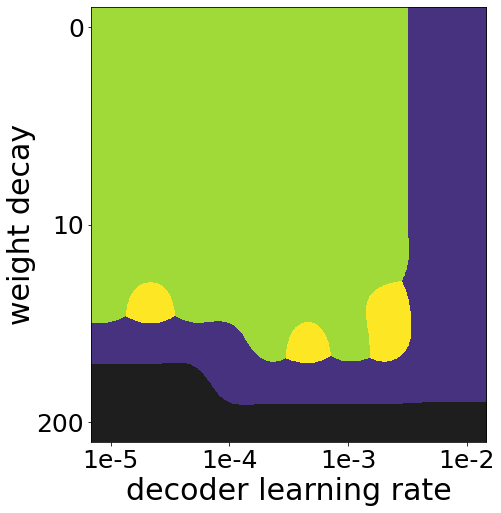

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

shp = train_iterss.shape

palette = np.array([[160, 218, 57],   # green, compression
                    [253, 231, 37],   # yellow, grokking
                    [70, 50, 126],   # blue, memorization
                    [30,30,30]])  # black, confusion

palette = palette

id_mat = np.eye(4,)

steps = 1e4
threshold = 1e3
I = np.transpose((train_iterss < (steps -1))*(test_iterss < (steps-1))*((test_iterss-train_iterss)<threshold))*0 +np.transpose((train_iterss < (steps-1))*(test_iterss < (steps-1))*((test_iterss-train_iterss)>threshold))*1+np.transpose((train_iterss < (steps-1))*(test_iterss == (steps-1)))*2+np.transpose((train_iterss == (steps-1))*(test_iterss == (steps-1)))*3

RGB = id_mat[I]

import torch
scale = 100
RGBt = np.transpose(RGB, (2,0,1))
RGBt = torch.nn.functional.interpolate(torch.tensor(np.array([RGBt]).astype(np.float64)), scale_factor=scale, mode="bicubic")
RGBt = np.transpose(RGBt[0], (1,2,0)).detach().numpy()

I = np.argmin(np.mean((RGBt.reshape(shp[0]*shp[1]*scale**2,4)[np.newaxis,:]-id_mat[:,np.newaxis,:])**2, axis=2), axis=0).reshape(shp[1]*scale, shp[0]*scale)
RGB = palette[I]

plt.xlabel("decoder learning rate",fontsize=30)
plt.ylabel("weight decay",fontsize=30, labelpad=-0)
plt.yticks([0+int(scale/2),int(5.5*scale),int(10.5*scale)],[wds[0], wds[5], wds[10]],fontsize=25)
plt.xticks([0+int(scale/2),int(3.5*scale),int(6.5*scale),int(9.5*scale)], ["1e-5", "1e-4", "1e-3", "1e-2"],fontsize=25)


plt.imshow(RGB[:,::-1], interpolation="nearest", alpha=1.0, aspect=1.)